# Predicting risky decision making using fMRI and Recurrent Neural Networks

# Setting Up (Run this block to import, install and download everything necessary)

In [ ]:
#Install dependencies
!pip install nilearn --quiet

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from nilearn import plotting, datasets
from nilearn.surface import vol_to_surf

#Figure
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

#Downloading Data File
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

#Loading region info
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

#Help Function
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """Load timeseries data for a single subject and single run.

    Args:
        subject (str):      subject ID to load
        experiment (str):   Name of experiment
        run (int):          (0 or 1)
        remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

    Returns
        ts (n_parcel x n_timepoint array): Array of BOLD data values

    """
    bold_run  = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts


def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Args:
        subject (str): subject ID to load
        experiment (str) : Name of experiment
        run (int): 0 or 1

    Returns
        evs (list of lists): A list of frames associated with each condition

    """
    frames_list = []
    task_key = f'tfMRI_{experiment}_{RUNS[run]}'
    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)

    return frames_list

# Function to average frames from any given condition
def average_frames(data, evs, experiment, cond):
    idx = EXPERIMENTS[experiment]["cond"].index(cond)
    return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 12.5 MB/s eta 0:00:00


## Libraries


In [ ]:
import os, requests
import numpy as np
from scipy import interp
from nilearn import datasets, plotting, surface
from nilearn.image import index_img
from nilearn.regions import RegionExtractor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam

## Identifying the DMN Parcel Indices




In [ ]:
# Load the region information
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Find indices of parcels corresponding to the DMN (labeled as "Default")
dmn_indices = [i for i, network in enumerate(region_info['network']) if network == 'Default']

# Print the indices
print("Indices of parcels corresponding to the DMN:")
print(dmn_indices)

Indices of parcels corresponding to the DMN:
[11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]


## Subject IDs

In [ ]:
dir = "./hcp_task/subjects"
subject_ids = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f))]

# Visualizing the DMN

### Visualize the DMN (for the poster)

In [ ]:
# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

    with np.load(fname) as dobj:
        atlas = dict(**dobj)

In [ ]:
# Load the region information
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Find indices of parcels corresponding to the DMN (labeled as "Default")
dmn_indices = [i for i, network in enumerate(region_info['network']) if network == 'Default']

# Prepare the contrast for visualization
group_contrast = np.zeros(len(region_info['name']))
for idx in dmn_indices:
    group_contrast[idx] = 1  # Set DMN parcels to 1

# Fetch the fsaverage surface
fsaverage = datasets.fetch_surf_fsaverage()

# Assuming the correct keys are found, replace 'labels_L' with the appropriate key
# Replace 'labels_L' with the actual key for left hemisphere labels
surf_contrast = group_contrast[atlas["labels_L"] - 1]

#### Plot2 ([Source code](https://nilearn.github.io/dev/auto_examples/06_manipulating_images/plot_extract_rois_smith_atlas.html))
[Colormap codes](https://https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html)

In [ ]:
atlas_networks = datasets.fetch_atlas_smith_2009(resting=True, dimension=10)[
    "maps"
]

# min_region_size in voxel volume mm^3
extraction = RegionExtractor(
    atlas_networks,
    min_region_size=800,
    threshold=98,
    thresholding_strategy="percentile",
)

# Just call fit() to execute region extraction procedure
extraction.fit()
regions_img = extraction.regions_img_


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/smith_2009



 ...done. (0 seconds, 0 min)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


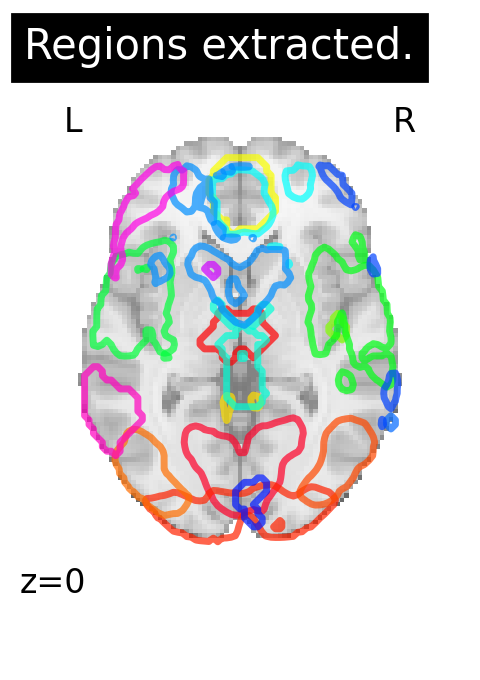

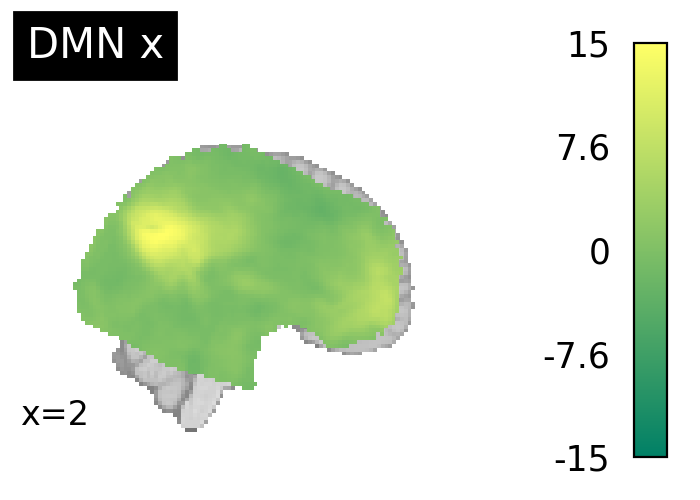

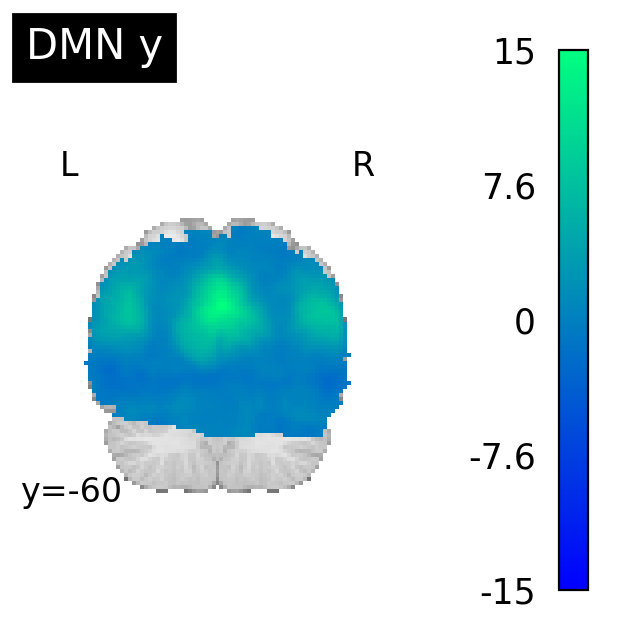

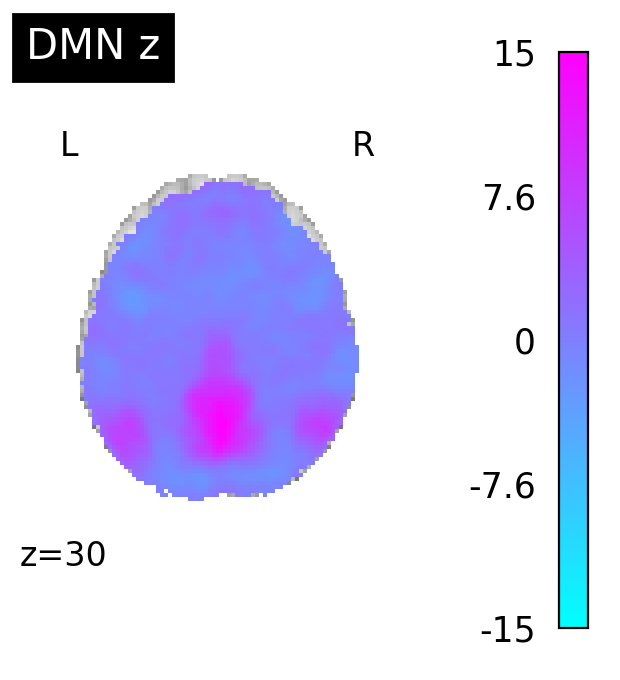

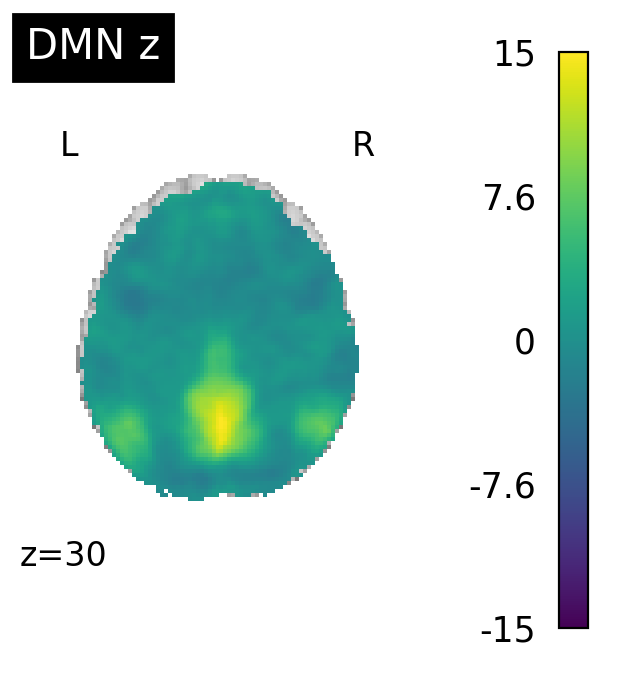

In [ ]:
# Showing region extraction results using 4D maps visualization tool
plotting.plot_prob_atlas(
    regions_img,
    display_mode="z",
    cut_coords=1,
    view_type="contours",
    title="Regions extracted.",
)

# To reduce the complexity, we choose to display all the regions
# extracted from network 3

DMN_network = index_img(atlas_networks, 3)
plotting.plot_stat_map(
    DMN_network,
    display_mode="x",
    cut_coords=1,
    title="DMN x",
    colorbar=True,
    cmap="summer"
)

plotting.plot_stat_map(
    DMN_network,
    display_mode="y",
    cut_coords=1,
    title="DMN y",
    colorbar=True,
    cmap="winter"
)

plotting.plot_stat_map(
    DMN_network,
    display_mode="z",
    cut_coords=1,
    title="DMN z",
    colorbar=True,
    cmap="cool"
)

plotting.plot_stat_map(
    DMN_network,
    display_mode="z",
    cut_coords=1,
    title="DMN z",
    colorbar=True,
    cmap="viridis"
)

plotting.show()

#### Plot...

In [ ]:
# Check the keys in the atlas dictionary
print(atlas.keys())

# Load the region information
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Find indices of parcels corresponding to the DMN (labeled as "Default")
dmn_indices = [i for i, network in enumerate(region_info['network']) if network == 'Default']

# Print the indices
print("Indices of parcels corresponding to the DMN:")
print(dmn_indices)

# Prepare the contrast for visualization
group_contrast = np.zeros(len(region_info['name']))
for idx in dmn_indices:
    group_contrast[idx] = 1  # Set DMN parcels to 1

# Fetch the fsaverage surface
fsaverage = datasets.fetch_surf_fsaverage()

# Assuming the correct keys are found, replace 'labels_L' with the appropriate key
# Prepare the surf_contrast for the left hemisphere
surf_contrast = group_contrast[atlas["labels_L"].astype(int) - 1]

# Visualize the DMN regions on the left hemisphere
view = plotting.view_surf(fsaverage['infl_left'],
                          surf_contrast,
                          vmax=1,
                          cmap='autumn',  # Use a colormap with high contrast
                          title='DMN Regions',
                          symmetric_cmap=False)

# Save the interactive plot to an HTML file in the current directory
output_file = 'dmn_regions.html'
view.save_as_html(output_file)
print(f"Interactive plot saved as {output_file}")


# Display the interactive plot inline (only if the environment supports it)
view

dict_keys(['labels_R', 'labels_L', 'coords'])
Indices of parcels corresponding to the DMN:
[11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]
Interactive plot saved as dmn_regions.html


# Building a GLM and Predicting Gambling Outcomes

In [ ]:

import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define DMN parcels
DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare data
X = []  # Independent variables
y = []  # Dependent variable

# Loop through each subject and each run
for subject in subject_ids:
    for run in range(2):  # Assuming there are 2 runs: run 0 and run 1
        timeseries = load_single_timeseries(subject, 'GAMBLING', run)
        evs = load_evs(subject, 'GAMBLING', run)

        for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
            average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
            important_data = average_data[DMN_PARCELS]
            X.append(important_data)
            y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add an intercept
X_scaled = sm.add_constant(X_scaled)

# K-Fold Cross-Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists for saving the results
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Specify and adapt GLM model
    model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
    results = model.fit()

    # Predictions based on test data
    y_pred_prob = results.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred_prob))

# Calculate average metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_aucs)

print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1 Score: {mean_f1_score:.4f}')
print(f'Mean ROC AUC: {mean_roc_auc:.4f}')

print(results.summary())



Mean Accuracy: 0.6400
Mean Precision: 0.6563
Mean Recall: 0.6328
Mean F1 Score: 0.6323
Mean ROC AUC: 0.7109
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  360
Model:                            GLM   Df Residuals:                      336
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -195.56
Date:                Wed, 24 Jul 2024   Deviance:                       391.12
Time:                        07:45:33   Pearson chi2:                     352.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2591
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

#Building an LSTM and Predicting Gambling Outcomes (Win/Loss)

In [26]:

# USING THE DMN PARCEL TIMESERIES TO PREDICT GAMBLING OUTCOME (WIN/LOSS)

DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare train data
X = []
y = []

for subject in subject_ids:
    timeseries_run0 = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_run1 = load_single_timeseries(subject, 'GAMBLING', 1)
    timeseries = np.concatenate((timeseries_run0, timeseries_run1), axis=1)

    evs_run0 = load_evs(subject, 'GAMBLING', 0)
    evs_run1 = load_evs(subject, 'GAMBLING', 1)
    evs = np.concatenate((evs_run0, evs_run1), axis=0)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# k-fold cross validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42).split(X_scaled, y)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

accus = []
fprs = []
tprs = []
aucs = []  # AUC values
ppvs = []  # PPV values
npvs = []  # NPV values
senses = []  # Sensitivity values
specs = []  # Specificity values
cms = []  # Confusion Matrices
mean_fpr = np.linspace(0, 1, 100)

cnn_hists = []

for train_idx, test_idx in kf:
    X_train, X_val = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Increased regularization
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    hist = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
    preds_prob = model.predict(X_val).ravel()
    preds = preds_prob.round()

    accus.append(accuracy_score(y_val, preds))

    fpr, tpr, thresholds = roc_curve(y_val, preds_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc(fpr, tpr))

    cm = confusion_matrix(y_val, preds)
    cms.append(confusion_matrix(y_val, preds))

    ppv = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    ppvs.append(ppv)

    npv = cm[0, 0] / (cm[0, 0] + cm[1, 0])
    npvs.append(npv)

    sens = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    senses.append(sens)

    spec = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specs.append(spec)

    train_loss.append(hist.history['loss'])
    train_acc.append(hist.history['accuracy'])
    val_loss.append(hist.history['val_loss'])
    val_acc.append(hist.history['val_accuracy'])

    cnn_hists.append(hist)

print("Avg Accuracy:", np.mean(accus))
print("Avg AUC:", np.mean(aucs))
print("Avg PPV:", np.mean(ppvs))
print("Avg NPV:", np.mean(npvs))
print("Avg Sensitivity:", np.mean(senses))
print("Avg Specificity:", np.mean(specs))




Epoch 1/100
6/6 [==============================] - 29s 501ms/step - loss: 1.9430 - accuracy: 0.4389 - val_loss: 1.8618 - val_accuracy: 0.4500
Epoch 2/100
6/6 [==============================] - 0s 27ms/step - loss: 1.8137 - accuracy: 0.4778 - val_loss: 1.7397 - val_accuracy: 0.5500
Epoch 3/100
6/6 [==============================] - 0s 40ms/step - loss: 1.6965 - accuracy: 0.5222 - val_loss: 1.6282 - val_accuracy: 0.5500
Epoch 4/100
6/6 [==============================] - 0s 45ms/step - loss: 1.5877 - accuracy: 0.5722 - val_loss: 1.5266 - val_accuracy: 0.6500
Epoch 5/100
6/6 [==============================] - 0s 31ms/step - loss: 1.4912 - accuracy: 0.6111 - val_loss: 1.4350 - val_accuracy: 0.7000
Epoch 6/100
6/6 [==============================] - 0s 35ms/step - loss: 1.4025 - accuracy: 0.6056 - val_loss: 1.3520 - val_accuracy: 0.7500
Epoch 7/100
6/6 [==============================] - 0s 23ms/step - loss: 1.3214 - accuracy: 0.6444 - val_loss: 1.2778 - val_accuracy: 0.6500
Epoch 8/100
6/6 [=

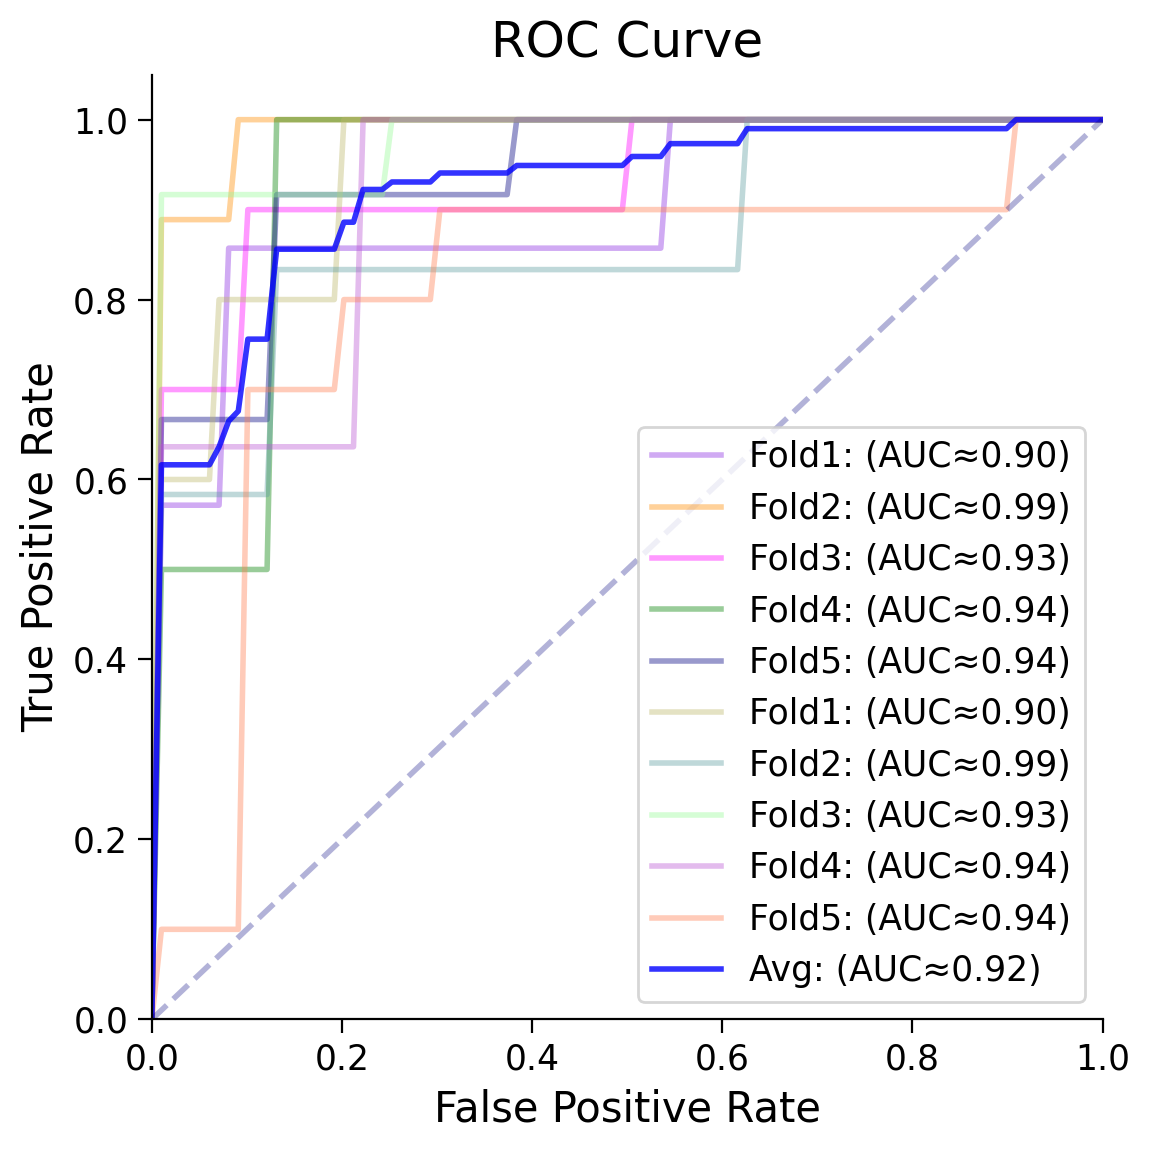

In [ ]:
# ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, tprs[0], color="blueviolet", label=r"Fold1: (AUC≈%0.2f)" % (aucs[0]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[1], color="darkorange", label=r"Fold2: (AUC≈%0.2f)" % (aucs[1]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[2], color="magenta", label=r"Fold3: (AUC≈%0.2f)" % (aucs[2]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[3], color="green", label=r"Fold4: (AUC≈%0.2f)" % (aucs[3]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[4], color="navy", label=r"Fold5: (AUC≈%0.2f)" % (aucs[4]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[5], color="darkkhaki", label=r"Fold1: (AUC≈%0.2f)" % (aucs[0]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[6], color="cadetblue", label=r"Fold2: (AUC≈%0.2f)" % (aucs[1]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[7], color="palegreen", label=r"Fold3: (AUC≈%0.2f)" % (aucs[2]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[8], color="mediumorchid", label=r"Fold4: (AUC≈%0.2f)" % (aucs[3]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[9], color="coral", label=r"Fold5: (AUC≈%0.2f)" % (aucs[4]), lw=2, alpha=.4)
plt.plot(mean_fpr, mean_tpr, color="blue", label=r"Avg: (AUC≈%0.2f)" % (mean_auc), lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

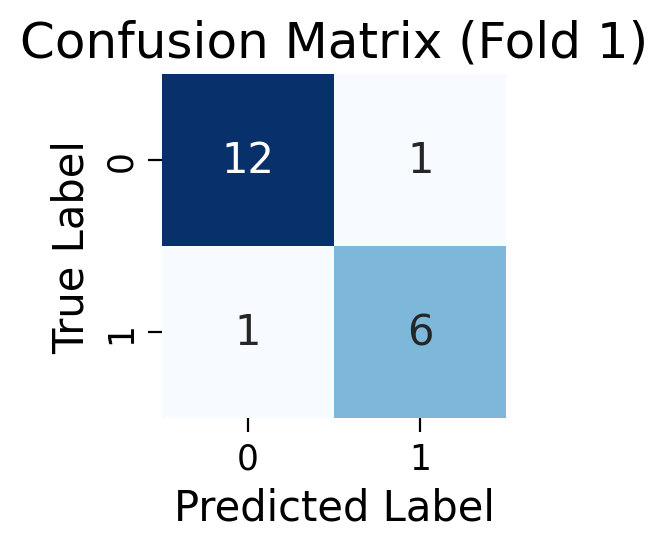

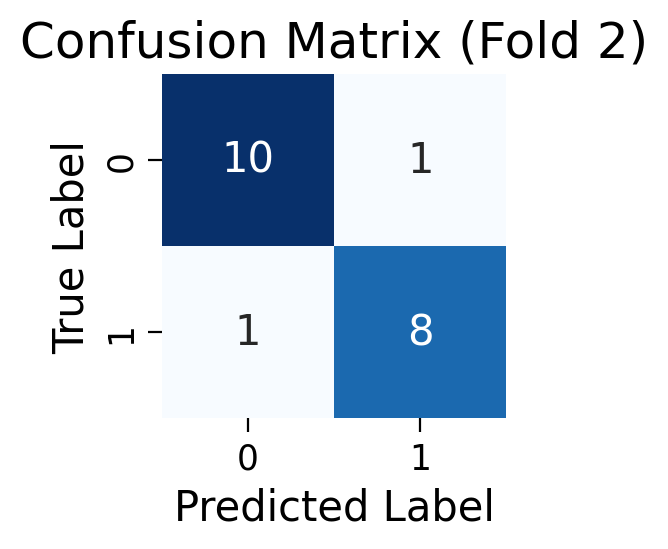

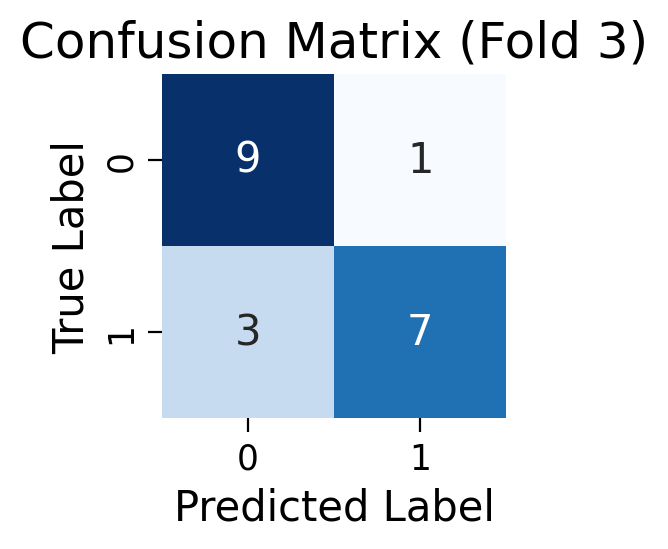

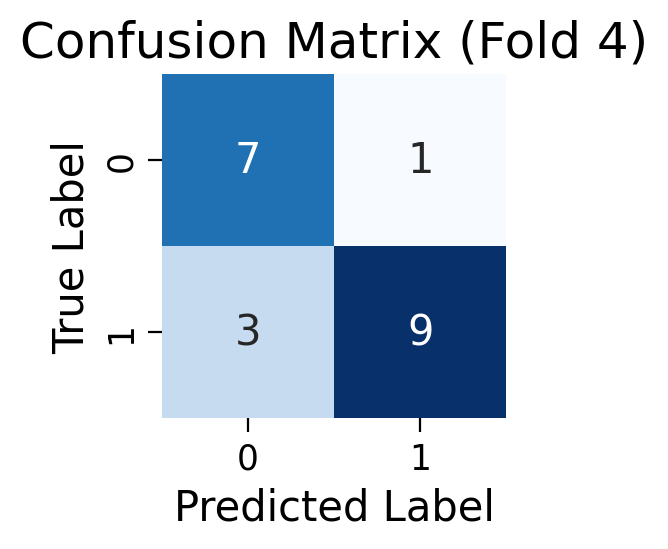

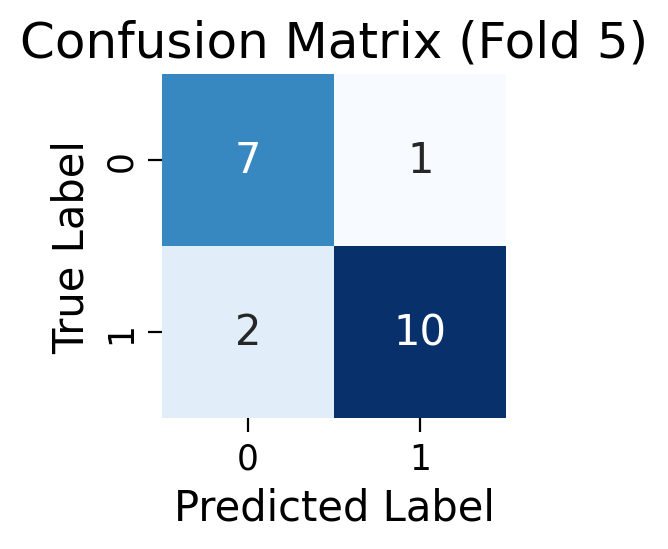

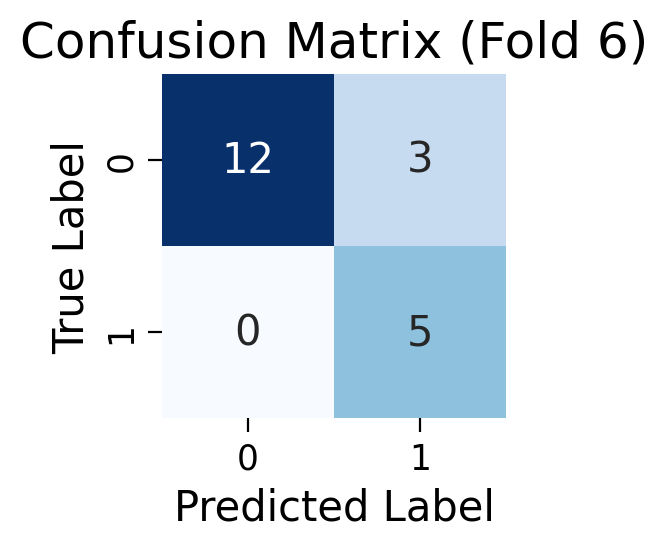

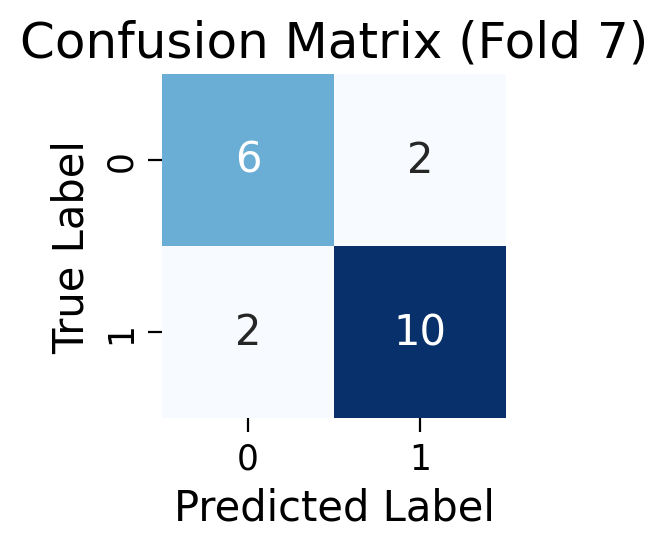

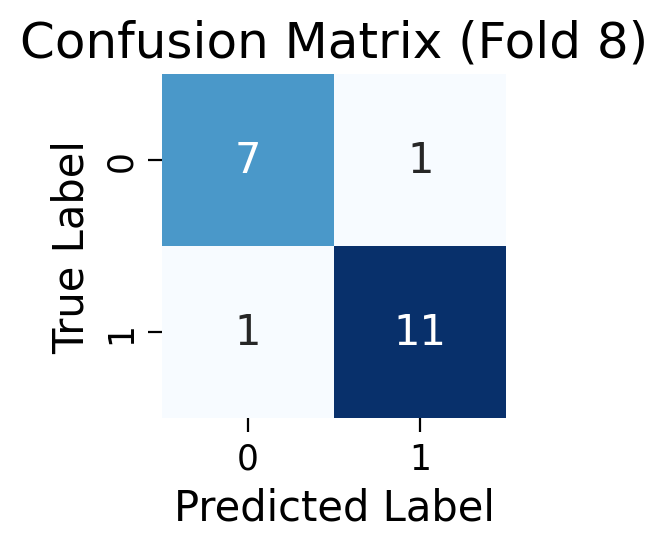

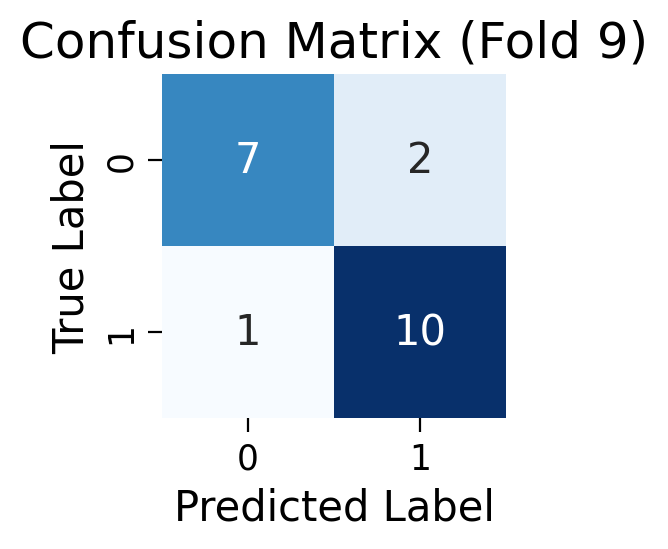

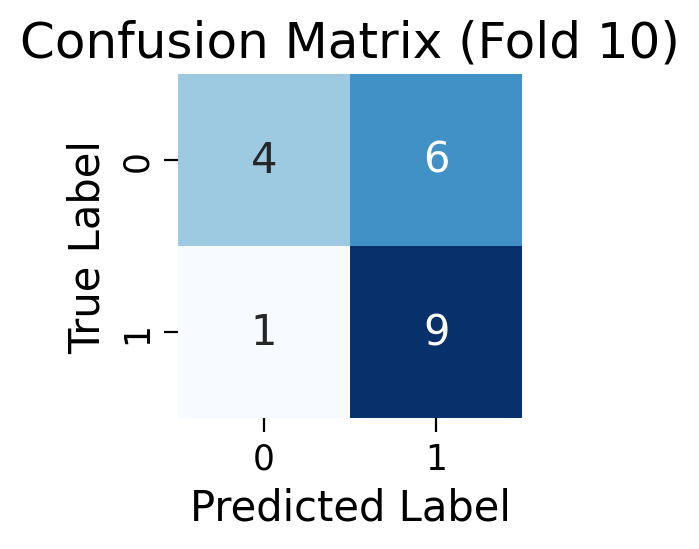

In [ ]:
# Confusion Matrices
plt.figure(figsize=(3, 3))
sns.heatmap(cms[0], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 1)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[1], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 2)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[2], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 3)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[3], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 4)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[4], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 5)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[5], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 6)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[6], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 7)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[7], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 8)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[8], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 9)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[9], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 10)")
plt.show()

#LSTM (Feature Selection) + PCA for Features -> GLM (Win/Loss)

In [ ]:

import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Define DMN parcels
DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare data
X = []  # Independent variables
y = []  # Dependent variable

for subject in subject_ids:
    timeseries_run0 = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_run1 = load_single_timeseries(subject, 'GAMBLING', 1)
    timeseries = np.concatenate((timeseries_run0, timeseries_run1), axis=1)

    evs_run0 = load_evs(subject, 'GAMBLING', 0)
    evs_run1 = load_evs(subject, 'GAMBLING', 1)
    evs = np.concatenate((evs_run0, evs_run1), axis=0)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)

X = np.array(X)
y = np.array(y)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold Cross-Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists for saving the results
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape for LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model with increased regularization
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    hist = model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

    # Using the LSTM to extract features
    feature_model = Sequential(model.layers[:-1])  # Use all layers except the last Dense layer
    X_train_features = feature_model.predict(X_train_lstm)
    X_test_features = feature_model.predict(X_test_lstm)

    # Dimensionality Reduction using PCA
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_train_features_pca = pca.fit_transform(X_train_features)
    X_test_features_pca = pca.transform(X_test_features)

    # Scaling the features for GLM
    scaler_features = StandardScaler()
    X_train_features_scaled = scaler_features.fit_transform(X_train_features_pca)
    X_test_features_scaled = scaler_features.transform(X_test_features_pca)

    # Adding an intercept for GLM
    X_train_features_scaled = sm.add_constant(X_train_features_scaled)
    X_test_features_scaled = sm.add_constant(X_test_features_scaled)

    # GLM model
    glm_model = sm.GLM(y_train, X_train_features_scaled, family=sm.families.Binomial())
    glm_results = glm_model.fit()

    # Predictions
    y_pred_prob = glm_results.predict(X_test_features_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculations
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred_prob))

# Average metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_aucs)

print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1 Score: {mean_f1_score:.4f}')
print(f'Mean ROC AUC: {mean_roc_auc:.4f}')



Epoch 1/100
6/6 [==============================] - 5s 204ms/step - loss: 1.9334 - accuracy: 0.4938 - val_loss: 1.8488 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 1.8070 - accuracy: 0.5185 - val_loss: 1.7292 - val_accuracy: 0.6111
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 1.6906 - accuracy: 0.5370 - val_loss: 1.6202 - val_accuracy: 0.6111
Epoch 4/100
6/6 [==============================] - 0s 14ms/step - loss: 1.5835 - accuracy: 0.6420 - val_loss: 1.5209 - val_accuracy: 0.6111
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 1.4888 - accuracy: 0.6049 - val_loss: 1.4307 - val_accuracy: 0.6111
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 1.4021 - accuracy: 0.5556 - val_loss: 1.3496 - val_accuracy: 0.6667
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 1.3240 - accuracy: 0.6358 - val_loss: 1.2767 - val_accuracy: 0.6667
Epoch 8/100
6/6 [==



---



#Additional Stuff

In [ ]:
#Code the GLM here

#USING THE DMN PARCEL TIMESERIES TO PREDICT GAMBLING OUTCOME (WIN/LOSS)

DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare data
X = [] #IV
y = [] #DV

for subject in subject_ids:
    timeseries = load_single_timeseries(subject, 'GAMBLING', 0)
    evs = load_evs(subject, 'GAMBLING', 0)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import statsmodels.api as sm
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# add an intercept
X = sm.add_constant(X)

# K-Fold-Cross-Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# lists for saving the results
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # specify and adapt GLM model
    model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
    results = model.fit()

    # predictions based on test data
    y_pred_prob = results.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred_prob))

# caculate average metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_aucs)

print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1 Score: {mean_f1_score:.4f}')
print(f'Mean ROC AUC: {mean_roc_auc:.4f}')


print(results.summary())
###############################################################################
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Define DMN parcels
DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare data
X = []  # Independent variables
y = []  # Dependent variable

for subject in subject_ids:
    timeseries_run0 = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_run1 = load_single_timeseries(subject, 'GAMBLING', 1)
    timeseries = np.concatenate((timeseries_run0, timeseries_run1), axis=1)

    evs_run0 = load_evs(subject, 'GAMBLING', 0)
    evs_run1 = load_evs(subject, 'GAMBLING', 1)
    evs = np.concatenate((evs_run0, evs_run1), axis=0)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold Cross-Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists for saving the results
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape for LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model with increased regularization
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    hist = model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

    # Use LSTM to extract features
    feature_model = Sequential(model.layers[:-1])  # Use all layers except the last Dense layer
    X_train_features = feature_model.predict(X_train_lstm)
    X_test_features = feature_model.predict(X_test_lstm)

    # Reduce dimensionality if necessary (e.g., using PCA)
    # For simplicity, we skip this step in the current code

    # Scale features for GLM
    scaler_features = StandardScaler()
    X_train_features_scaled = scaler_features.fit_transform(X_train_features)
    X_test_features_scaled = scaler_features.transform(X_test_features)

    # Add an intercept for GLM
    X_train_features_scaled = sm.add_constant(X_train_features_scaled)
    X_test_features_scaled = sm.add_constant(X_test_features_scaled)

    # GLM model
    glm_model = sm.GLM(y_train, X_train_features_scaled, family=sm.families.Binomial())
    glm_results = glm_model.fit()

    # Predictions
    y_pred_prob = glm_results.predict(X_test_features_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred_prob))

# Calculate average metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_aucs)

print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1 Score: {mean_f1_score:.4f}')
print(f'Mean ROC AUC: {mean_roc_auc:.4f}')
###############################################################################

import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.optimizers import Adam

# Define DMN parcels
DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare data
X = []  # Independent variables
y = []  # Dependent variable

for subject in subject_ids:
    timeseries_run0 = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_run1 = load_single_timeseries(subject, 'GAMBLING', 1)
    timeseries = np.concatenate((timeseries_run0, timeseries_run1), axis=1)

    evs_run0 = load_evs(subject, 'GAMBLING', 0)
    evs_run1 = load_evs(subject, 'GAMBLING', 1)
    evs = np.concatenate((evs_run0, evs_run1), axis=0)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold Cross-Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists for saving the results
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape for LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model with increased regularization and complexity
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    hist = model.fit(X_train_lstm, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Use LSTM to extract features
    feature_model = Sequential(model.layers[:-1])  # Use all layers except the last Dense layer
    X_train_features = feature_model.predict(X_train_lstm)
    X_test_features = feature_model.predict(X_test_lstm)

    # Reduce dimensionality using PCA
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_train_features_pca = pca.fit_transform(X_train_features)
    X_test_features_pca = pca.transform(X_test_features)

    # Scale features for GLM
    scaler_features = StandardScaler()
    X_train_features_scaled = scaler_features.fit_transform(X_train_features_pca)
    X_test_features_scaled = scaler_features.transform(X_test_features_pca)

    # Add an intercept for GLM
    X_train_features_scaled = sm.add_constant(X_train_features_scaled)
    X_test_features_scaled = sm.add_constant(X_test_features_scaled)

    # GLM model
    glm_model = sm.GLM(y_train, X_train_features_scaled, family=sm.families.Binomial())
    glm_results = glm_model.fit()

    # Predictions
    y_pred_prob = glm_results.predict(X_test_features_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred_prob))

# Calculate average metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_aucs)

print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1 Score: {mean_f1_score:.4f}')
print(f'Mean ROC AUC: {mean_roc_auc:.4f}')

####################################

# Fetch the Glasser atlas
atlas = fetch_atlas_glasser_2016()
atlas_filename = atlas['maps']
labels = atlas['labels']

# Define the indices for the DMN regions
dmn_indices = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Create a mask for the DMN regions
dmn_mask = np.zeros(atlas_filename.shape, dtype=bool)
for idx in dmn_indices:
    dmn_mask[atlas_filename == idx + 1] = True  # +1 because atlas labels start from 1

# Plot the DMN regions using nilearn
display = plotting.plot_roi(
    dmn_mask,
    title="Default Mode Network (DMN) Regions",
    display_mode='ortho',  # You can change this to 'ortho', 'x', 'y', 'z' to view different planes
    cut_coords=(0, 0, 0),  # Adjust as needed to center the brain
    draw_cross=False,
    cmap='autumn'  # Color map for the DMN regions
)

# Display the plot
plt.show()

####################################################################################

#IDENTIFYING PARCELS WITH HIGHEST AVERAGE RESPONSE FOR 'WIN' AND 'LOSS' CONDITIONS

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define constants
HCP_DIR = "./hcp_task"
TR = 0.72
RUNS = ['LR', 'RL']
N_PARCELS = 360
EXPERIMENTS = {
    'GAMBLING': {'cond': ['loss', 'win']}
}

# Helper function to load timeseries data
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    bold_run = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts

# Helper function to load EVs data
def load_evs(subject, experiment, run):
    frames_list = []
    task_key = f'tfMRI_{experiment}_{RUNS[run]}'
    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
        start = np.floor(ev["onset"] / TR).astype(int)
        duration = np.ceil(ev["duration"] / TR).astype(int)
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)
    return frames_list

#####################################################################################

# Function to average frames from any given condition
def average_frames(data, evs, experiment, cond):
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

# List of subject IDs
subject_ids = [
    '100307', '100408', '101915', '102816', '103414', '103515', '103818', '105115', '105216', '106016',
    '106319', '110411', '111009', '111312', '111514', '111716', '113215', '113619', '114924', '115320',
    '117122', '117324', '118730', '118932', '119833', '120111', '120212', '122317', '123117', '124422',
    '125525', '126325', '127933', '128632', '129028', '130013', '130316', '130922', '131924', '133625',
    '133827', '133928', '134324', '135932', '136833', '137128', '138231', '138534', '139637', '140824',
    '142828', '143325', '148032', '148335', '149337', '149539', '150524', '151223', '151526', '151627',
    '153025', '153429', '154431', '156233', '156637', '157336', '158035', '158540', '159239', '159340',
    '160123', '161731', '162329', '162733', '163129', '163432', '167743', '172332', '175439', '176542',
    '178950', '182739', '185139', '188347', '189450', '190031', '192439', '192540', '193239', '194140',
    '196144', '196750', '197550', '198451', '199150', '199655', '200614', '201111', '201414', '205119'
]


# Calculate average response across all parcels for 'loss' and 'win' conditions
all_average_responses_loss = np.zeros(N_PARCELS)
all_average_responses_win = np.zeros(N_PARCELS)

for subject in subject_ids:
    timeseries = load_single_timeseries(subject, 'GAMBLING', 0)
    evs = load_evs(subject, 'GAMBLING', 0)

    # Average response for 'loss' condition
    average_data_loss = average_frames(timeseries, evs, 'GAMBLING', 'loss')
    all_average_responses_loss += average_data_loss / len(subject_ids)

    # Average response for 'win' condition
    average_data_win = average_frames(timeseries, evs, 'GAMBLING', 'win')
    all_average_responses_win += average_data_win / len(subject_ids)

# Identify the top 10 parcels with the highest average response for 'loss'
top_parcel_indices_loss = np.argsort(-all_average_responses_loss)[:10]
top_average_responses_loss = all_average_responses_loss[top_parcel_indices_loss]

# Identify the top 10 parcels with the highest average response for 'win'
top_parcel_indices_win = np.argsort(-all_average_responses_win)[:10]
top_average_responses_win = all_average_responses_win[top_parcel_indices_win]

# Printing results for 'loss' condition
print("Top 10 parcels with highest average response for 'loss' (descending order):")
for i, index in enumerate(top_parcel_indices_loss):
    print(f"Parcel index {index}: Average response = {top_average_responses_loss[i]}")

print("\n")

# Printing results for 'win' condition
print("Top 10 parcels with highest average response for 'win' (descending order):")
for i, index in enumerate(top_parcel_indices_win):
    print(f"Parcel index {index}: Average response = {top_average_responses_win[i]}")


# Plotting histograms of top average responses for 'loss' and 'win' conditions
plt.figure(figsize=(12, 6))

# Histogram for 'loss' condition
plt.subplot(1, 2, 1)
plt.hist(top_average_responses_loss, bins=10, color='blue', alpha=0.7)
plt.title('Histogram of Top Average Responses for "Loss" Condition')
plt.xlabel('Average Response')
plt.ylabel('Frequency')

# Histogram for 'win' condition
plt.subplot(1, 2, 2)
plt.hist(top_average_responses_win, bins=10, color='green', alpha=0.7)
plt.title('Histogram of Top Average Responses for "Win" Condition')
plt.xlabel('Average Response')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#####################################################################################################################################################

#STEP-2: IDENTIFYING PARCELS WITH HIGHEST FUNCTIONAL CONNECTIVITY FOR 'WIN' AND 'LOSS' CONDITIONS

import os, requests
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, datasets
from scipy import stats

# Function to calculate functional connectivity
def calculate_functional_connectivity(timeseries):
    correlation_matrix = np.corrcoef(timeseries)
    return correlation_matrix

# Calculate functional connectivity for each subject and condition
all_fc_loss = np.zeros((N_PARCELS, N_PARCELS))
all_fc_win = np.zeros((N_PARCELS, N_PARCELS))

for subject in subject_ids:
    # Load timeseries data for both conditions
    timeseries_loss = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_win = load_single_timeseries(subject, 'GAMBLING', 1)

    # Calculate functional connectivity
    fc_loss = calculate_functional_connectivity(timeseries_loss)
    fc_win = calculate_functional_connectivity(timeseries_win)

    all_fc_loss += fc_loss / len(subject_ids)
    all_fc_win += fc_win / len(subject_ids)

# Calculate average connectivity strength for each parcel
average_connectivity_loss = np.mean(np.abs(all_fc_loss), axis=1)
average_connectivity_win = np.mean(np.abs(all_fc_win), axis=1)

# Identify the top 10 parcels with the highest average connectivity strength for 'loss'
top_parcel_indices_loss = np.argsort(-average_connectivity_loss)[:10]
top_average_connectivity_loss = average_connectivity_loss[top_parcel_indices_loss]

# Identify the top 10 parcels with the highest average connectivity strength for 'win'
top_parcel_indices_win = np.argsort(-average_connectivity_win)[:10]
top_average_connectivity_win = average_connectivity_win[top_parcel_indices_win]

# Print results for 'loss' condition
print("Top 10 parcels with highest average connectivity strength for 'loss':")
for i, index in enumerate(top_parcel_indices_loss):
    print(f"Parcel index {index}: Average connectivity strength = {top_average_connectivity_loss[i]}")

# Print results for 'win' condition
print("\nTop 10 parcels with highest average connectivity strength for 'win':")
for i, index in enumerate(top_parcel_indices_win):
    print(f"Parcel index {index}: Average connectivity strength = {top_average_connectivity_win[i]}")

print("\n")

garbage_average_connectivity_loss = np.delete(average_connectivity_loss, top_parcel_indices_loss)
avg_garbage = np.mean(garbage_average_connectivity_loss)

t_statistic, p_value = stats.ttest_1samp(top_average_connectivity_loss, avg_garbage)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

#Combining all the "important parcels" for win and loss conditions

IMPORTANT_PARCELS_WIN = [0, 3, 5, 6, 9, 19, 20, 83, 142, 148, 180, 183, 185, 186, 198, 263, 265, 327]
IMPORTANT_PARCELS_LOSS = [3, 5, 6, 14, 18, 19, 20, 21, 79, 83, 85, 110, 142, 155, 186, 187, 188, 231, 263, 265]
print(f"Important Parcel Indices for 'WIN' Condition: {IMPORTANT_PARCELS_WIN}")
print(f"Important Parcels Indices for 'LOSS' Condition: {IMPORTANT_PARCELS_LOSS}")

###############################################################################################################
# Define a threshold for functional connectivity strength
threshold = 0.26  # Adjust this threshold as needed

# Identify parcels with connectivity strength above the threshold for 'win' condition
top_parcel_indices_win = np.where(np.abs(average_connectivity_win) > threshold)[0]
top_average_connectivity_win = average_connectivity_win[top_parcel_indices_win]

# Identify parcels with connectivity strength above the threshold for 'loss' condition
top_parcel_indices_loss = np.where(np.abs(average_connectivity_loss) > threshold)[0]
top_average_connectivity_loss = average_connectivity_loss[top_parcel_indices_loss]

# Print results for 'loss' condition
print("Top parcels with connectivity strength above threshold for 'loss':")
for i, index in enumerate(top_parcel_indices_loss):
    print(f"Parcel index {index}: Average connectivity strength = {top_average_connectivity_loss[i]}")

# Print results for 'win' condition
print("\nTop parcels with connectivity strength above threshold for 'win':")
for i, index in enumerate(top_parcel_indices_win):
    print(f"Parcel index {index}: Average connectivity strength = {top_average_connectivity_win[i]}")


####################################

# Assuming you have performed the t-test and obtained the p-values stored in p_values_win and p_values_loss

"""alpha = 0.05

# Select parcels with p-value less than 0.05 for 'win' condition
significant_parcel_indices_win = np.where(p_values_win < alpha)[0]

# Print significant parcels for 'win' condition
print(f"Significant parcels for 'win' condition (p < {alpha}):")
for index in significant_parcel_indices_win:
    print(f"Parcel index {index}: p-value = {p_values_win[index]}")

# Select parcels with p-value less than 0.05 for 'loss' condition
significant_parcel_indices_loss = np.where(p_values_loss < alpha)[0]

# Print significant parcels for 'loss' condition
print(f"\nSignificant parcels for 'loss' condition (p < {alpha}):")
for index in significant_parcel_indices_loss:
    print(f"Parcel index {index}: p-value = {p_values_loss[index]}")"""

# significant_parcel_indices_win and significant_parcel_indices_loss contain the indices of parcels with p < 0.05

######################################################################################

import os
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate functional connectivity
def calculate_functional_connectivity(timeseries):
    correlation_matrix = np.corrcoef(timeseries)
    return correlation_matrix

# Calculate functional connectivity for each subject and condition
all_fc_loss = np.zeros((N_PARCELS, N_PARCELS))
all_fc_win = np.zeros((N_PARCELS, N_PARCELS))

for subject in subject_ids:
    # Load timeseries data for both conditions
    timeseries_loss = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_win = load_single_timeseries(subject, 'GAMBLING', 1)

    # Calculate functional connectivity
    fc_loss = calculate_functional_connectivity(timeseries_loss)
    fc_win = calculate_functional_connectivity(timeseries_win)

    all_fc_loss += fc_loss / len(subject_ids)
    all_fc_win += fc_win / len(subject_ids)

# Flatten the connectivity matrices to get all pairwise connectivity values
fc_loss_values = all_fc_loss.flatten()
fc_win_values = all_fc_win.flatten()

# Plotting histograms to visualize the distribution of connectivity values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(fc_loss_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Functional Connectivity Values for Loss Condition')
plt.xlabel('Functional Connectivity Values')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(fc_win_values, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Functional Connectivity Values for Win Condition')
plt.xlabel('Functional Connectivity Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

####################################################################

import os
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate functional connectivity
def calculate_functional_connectivity(timeseries):
    correlation_matrix = np.corrcoef(timeseries)
    return correlation_matrix

# Example constants and variables (replace with your actual data)
N_PARCELS = 360
subject_ids = [101, 102, 103]  # Example subject IDs
HCP_DIR = "./hcp_task"  # Example path
RUNS = ['LR', 'RL']  # Example runs
EXPERIMENTS = {
    'GAMBLING': {'cond': ['loss', 'win']}
}

# Function to load timeseries data (replace with your actual function)
def load_single_timeseries(subject, experiment, run):
    # Example implementation, replace with your actual loading logic
    timeseries = np.random.rand(N_PARCELS, 100)  # Example random timeseries
    return timeseries

# Calculate functional connectivity for each subject and condition
all_fc_loss = np.zeros((N_PARCELS, N_PARCELS))
all_fc_win = np.zeros((N_PARCELS, N_PARCELS))

for subject in subject_ids:
    # Load timeseries data for both conditions
    timeseries_loss = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_win = load_single_timeseries(subject, 'GAMBLING', 1)

    # Calculate functional connectivity
    fc_loss = calculate_functional_connectivity(timeseries_loss)
    fc_win = calculate_functional_connectivity(timeseries_win)

    all_fc_loss += fc_loss / len(subject_ids)
    all_fc_win += fc_win / len(subject_ids)

# Flatten the connectivity matrices to get all pairwise connectivity values
fc_loss_values = np.abs(all_fc_loss.flatten())
fc_win_values = np.abs(all_fc_win.flatten())

# Plotting histograms to visualize the distribution of connectivity values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(fc_loss_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Functional Connectivity Values for Loss Condition')
plt.xlabel('Functional Connectivity Values')
plt.ylabel('Frequency')

# Calculate and plot threshold for loss condition
threshold_loss = np.percentile(fc_loss_values, 10)  # Example using 10th percentile
plt.axvline(x=threshold_loss, color='red', linestyle='--', linewidth=2, label=f'10th Percentile Threshold: {threshold_loss:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(fc_win_values, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Functional Connectivity Values for Win Condition')
plt.xlabel('Functional Connectivity Values')
plt.ylabel('Frequency')

# Calculate and plot threshold for win condition
threshold_win = np.percentile(fc_win_values, 10)  # Example using 10th percentile
plt.axvline(x=threshold_win, color='red', linestyle='--', linewidth=2, label=f'10th Percentile Threshold: {threshold_win:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print the calculated thresholds
print(f"Threshold for 'loss' condition: {threshold_loss:.2f}")
print(f"Threshold for 'win' condition: {threshold_win:.2f}")

#####################################################################################

# Visualize the 2D connectivity matrices
def plot_connectivity_matrix(connectivity_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(connectivity_matrix, cmap='coolwarm', center=0, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.show()

# Plot the connectivity matrices
plot_connectivity_matrix(all_fc_loss, 'Average Functional Connectivity (Loss Condition)')
plot_connectivity_matrix(all_fc_win, 'Average Functional Connectivity (Win Condition)')


# NMA provides an atlas. Load it along with the labels etc.
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

fname = f"{HCP_DIR}/atlas.npz"
atlas_data = np.load(fname, allow_pickle=True)
labels_L = atlas_data['labels_L']  # Left hemisphere labels from the atlas

# Plotting functional connectivity on the brain surface
# Fetch the fsaverage surface template
fsaverage = datasets.fetch_surf_fsaverage()

# Plot functional connectivity for 'loss' condition
fig_loss = plotting.plot_surf_stat_map(
    fsaverage.infl_left,
    np.mean(all_fc_loss, axis=1)[labels_L],  # Use mean or other aggregation method as per your data
    hemi='left',
    title='Functional Connectivity - Loss Condition',
    threshold=None,  # Adjust threshold as needed
    colorbar=True,
    cmap='coolwarm',  # Colormap
    bg_map=fsaverage.sulc_left,  # Sulcal depth as background
    view='lateral',  # View orientation
    symmetric_cbar=False,  # Ensure the colorbar is not symmetric
    darkness=0.5,  # Adjust darkness for better visibility
)

# Plot functional connectivity for 'win' condition
fig_win = plotting.plot_surf_stat_map(
    fsaverage.infl_left,
    np.mean(all_fc_win, axis=1)[labels_L],  # Use mean or other aggregation method as per your data
    hemi='left',
    title='Functional Connectivity - Win Condition',
    threshold=None,  # Adjust threshold as needed
    colorbar=True,
    cmap='coolwarm',  # Colormap
    bg_map=fsaverage.sulc_left,  # Sulcal depth as background
    view='lateral',  # View orientation
    symmetric_cbar=False,  # Ensure the colorbar is not symmetric
    darkness=0.5,  # Adjust darkness for better visibility
)

plt.show()


#####################################################################################
#DYNAMIC FC ANALYSIS

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, datasets

# Define constants
HCP_DIR = "./hcp_task"
TR = 0.72
RUNS = ['LR', 'RL']
N_PARCELS = 360
EXPERIMENTS = {
    'GAMBLING': {'cond': ['loss', 'win']}
}
WINDOW_SIZE = 100  # Define your window size in time points

# Helper function to load timeseries data
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    bold_run = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts

# Function to calculate functional connectivity for a given window
def calculate_functional_connectivity(timeseries):
    correlation_matrix = np.corrcoef(timeseries)
    return correlation_matrix

# Calculate functional connectivity using sliding window approach
def sliding_window_functional_connectivity(timeseries, window_size):
    num_timepoints = timeseries.shape[1]
    num_windows = num_timepoints - window_size + 1
    all_fc = np.zeros((N_PARCELS, N_PARCELS, num_windows))

    for i in range(num_windows):
        window_data = timeseries[:, i:i+window_size]
        fc = calculate_functional_connectivity(window_data)
        all_fc[:, :, i] = fc

    average_fc = np.mean(all_fc, axis=2)
    return average_fc

# List of subject IDs
subject_ids = [
    '100307', '100408', '101915', '102816', '103414', '103515', '103818', '105115', '105216', '106016',
    '106319', '110411', '111009', '111312', '111514', '111716', '113215', '113619', '114924', '115320',
    '117122', '117324', '118730', '118932', '119833', '120111', '120212', '122317', '123117', '124422',
    '125525', '126325', '127933', '128632', '129028', '130013', '130316', '130922', '131924', '133625',
    '133827', '133928', '134324', '135932', '136833', '137128', '138231', '138534', '139637', '140824',
    '142828', '143325', '148032', '148335', '149337', '149539', '150524', '151223', '151526', '151627',
    '153025', '153429', '154431', '156233', '156637', '157336', '158035', '158540', '159239', '159340',
    '160123', '161731', '162329', '162733', '163129', '163432', '167743', '172332', '175439', '176542',
    '178950', '182739', '185139', '188347', '189450', '190031', '192439', '192540', '193239', '194140',
    '196144', '196750', '197550', '198451', '199150', '199655', '200614', '201111', '201414', '205119'
]

# Calculate dynamic functional connectivity for each subject and condition
all_dynamic_fc_loss = np.zeros((N_PARCELS, N_PARCELS, N_PARCELS))
all_dynamic_fc_win = np.zeros((N_PARCELS, N_PARCELS, N_PARCELS))

for subject in subject_ids:
    # Load timeseries data for both conditions
    timeseries_loss = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_win = load_single_timeseries(subject, 'GAMBLING', 1)

    # Calculate dynamic functional connectivity
    dynamic_fc_loss = sliding_window_functional_connectivity(timeseries_loss, WINDOW_SIZE)
    dynamic_fc_win = sliding_window_functional_connectivity(timeseries_win, WINDOW_SIZE)

    all_dynamic_fc_loss += dynamic_fc_loss / len(subject_ids)
    all_dynamic_fc_win += dynamic_fc_win / len(subject_ids)

# Calculate average connectivity strength for each parcel
average_dynamic_connectivity_loss = np.mean(np.abs(all_dynamic_fc_loss), axis=2)
average_dynamic_connectivity_win = np.mean(np.abs(all_dynamic_fc_win), axis=2)

# Identify the top 10 parcels with the highest average dynamic connectivity strength for 'loss'
top_dynamic_parcel_indices_loss = np.argsort(-average_dynamic_connectivity_loss, axis=None)[:10]
top_average_dynamic_connectivity_loss = average_dynamic_connectivity_loss.flatten()[top_dynamic_parcel_indices_loss]

# Identify the top 10 parcels with the highest average dynamic connectivity strength for 'win'
top_dynamic_parcel_indices_win = np.argsort(-average_dynamic_connectivity_win, axis=None)[:10]
top_average_dynamic_connectivity_win = average_dynamic_connectivity_win.flatten()[top_dynamic_parcel_indices_win]

# Print results for 'loss' condition
print()
print("Top 10 parcels with highest average dynamic connectivity strength for 'loss':")
for i, index in enumerate(top_dynamic_parcel_indices_loss):
    row = index // N_PARCELS
    col = index % N_PARCELS
    print(f"Parcel index ({row}, {col}): Average dynamic connectivity strength = {top_average_dynamic_connectivity_loss[i]}")

# Print results for 'win' condition
print("\nTop 10 parcels with highest average dynamic connectivity strength for 'win':")
for i, index in enumerate(top_dynamic_parcel_indices_win):
    row = index // N_PARCELS
    col = index % N_PARCELS
    print(f"Parcel index ({row}, {col}): Average dynamic connectivity strength = {top_average_dynamic_connectivity_win[i]}")

print("\n")



####################

import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Define DMN parcels
DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare data
X = []
y = []

for subject in subject_ids:
    timeseries_run0 = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_run1 = load_single_timeseries(subject, 'GAMBLING', 1)

    # Average the two runs
    timeseries_avg = (timeseries_run0 + timeseries_run1) / 2

    evs_run0 = load_evs(subject, 'GAMBLING', 0)
    evs_run1 = load_evs(subject, 'GAMBLING', 1)

    # Assuming EVs are the same for both runs (you might need to check and handle if different)
    evs = evs_run0  # or combine evs_run0 and evs_run1 if they differ

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries_avg, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare time-series data for LSTM
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# GLM model
X_glm = sm.add_constant(X_scaled)
model_glm = sm.GLM(y, X_glm, family=sm.families.Binomial())
results_glm = model_glm.fit()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists for storing results
accuracies = []
aucs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)
final_predictions = []

for train_index, test_index in kf.split(X_scaled):
    X_train_glm, X_test_glm = X_glm[train_index], X_glm[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_lstm, X_test_lstm = X_lstm[train_index], X_lstm[test_index]

    # GLM training
    model_glm = sm.GLM(y_train, X_train_glm, family=sm.families.Binomial())
    results_glm = model_glm.fit()
    glm_preds_prob = results_glm.predict(X_test_glm)

    # LSTM training
    model_lstm = Sequential()
    model_lstm.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    lstm_preds_prob = model_lstm.predict(X_test_lstm).ravel()

    # Combine predictions
    combined_preds_prob = (glm_preds_prob + lstm_preds_prob) / 2
    combined_preds = (combined_preds_prob > 0.5).astype(int)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, combined_preds))
    aucs.append(roc_auc_score(y_test, combined_preds_prob))

    fpr, tpr, _ = roc_curve(y_test, combined_preds_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    final_predictions.append(combined_preds)

# Calculate mean TPR
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# Print results
print(f'Avg Accuracy: {np.mean(accuracies):.4f}')
print(f'Avg AUC: {np.mean(aucs):.4f}')

# Plot ROC Curve
plt.figure(figsize=(6, 6))
for i in range(len(aucs)):
    plt.plot(mean_fpr, tprs[i], lw=2, alpha=0.3, label=f'Fold {i+1} AUC: {aucs[i]:.2f}')
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=f'Mean AUC: {mean_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrices
cm = confusion_matrix(y_test, combined_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Last Fold)")
plt.show()

###################################

#Add the code here
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression

# Define DMN parcels
DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare data
X = []
y = []

for subject in subject_ids:
    for run in range(2):  # Include both runs
        timeseries = load_single_timeseries(subject, 'GAMBLING', run)
        evs = load_evs(subject, 'GAMBLING', run)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare time-series data for LSTM
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# GLM model
X_glm = sm.add_constant(X_scaled)
model_glm = sm.GLM(y, X_glm, family=sm.families.Binomial())
results_glm = model_glm.fit()

# LSTM model setup
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists for storing results
accuracies = []
aucs = []
final_predictions = []

for train_index, test_index in kf.split(X_scaled):
    X_train_glm, X_test_glm = X_glm[train_index], X_glm[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_lstm, X_test_lstm = X_lstm[train_index], X_lstm[test_index]

    # GLM training
    model_glm = sm.GLM(y_train, X_train_glm, family=sm.families.Binomial())
    results_glm = model_glm.fit()
    glm_preds_prob = results_glm.predict(X_test_glm)

    # LSTM training
    model_lstm = Sequential()
    model_lstm.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    lstm_preds_prob = model_lstm.predict(X_test_lstm).ravel()

    # Combine predictions
    combined_preds_prob = (glm_preds_prob + lstm_preds_prob) / 2
    combined_preds = (combined_preds_prob > 0.5).astype(int)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, combined_preds))
    aucs.append(roc_auc_score(y_test, combined_preds_prob))
    final_predictions.append(combined_preds)

# Print results
print(f'Avg Accuracy: {np.mean(accuracies):.4f}')
print(f'Avg AUC: {np.mean(aucs):.4f}')

# Confusion matrix for the last fold
cm = confusion_matrix(y_test, combined_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Last Fold)")
plt.show()

########################



